In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import scipy as sci
from requests import get
import folium
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

Importing database essentials and cleaning data

In [15]:
# Import CSV Files Extracted from the Earthquake Impact Database
data_2017 = pd.read_csv("2017_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2018 = pd.read_csv("2018_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

In [16]:
#Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2018 Data
data_2018 = data_2018.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2018 = data_2018.fillna(value = 0).replace("--", "0")
latlong_2018 = [0 for _ in range(0, len(data_2018.index))]
data_2018.insert(loc = 4, column = 'Lat', value = latlong_2018)
data_2018.insert(loc = 5, column = 'Long', value = latlong_2018)
data_2018 = data_2018.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2017 Data
data_2017 = data_2017.drop('Depth (km)', axis = 1).drop('Tsunami height', axis = 1)
data_2017 = data_2017.fillna(value = 0).replace("--", "0")
latlong_2017 = [0 for _ in range(0, len(data_2017.index))]
data_2017.insert(loc = 4, column = 'Lat', value = latlong_2017)
data_2017.insert(loc = 5, column = 'Long', value = latlong_2017)
data_2017 = data_2017.rename(columns = {"Impact coefficient (D)" : "Impact value (D)"} )

In [17]:
#Concatenate Dataframes into a Single Dataset
earthquake_data = pd.concat([data_2017, data_2018, data_2019, data_2020], sort = False).reset_index(drop = True)
Database = pd.concat([data_2019, data_2020], sort = False).reset_index(drop = True)

Cleaning and converting data

In [18]:
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('+',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('-',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('JMA',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('Shindo ','')

Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')


def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
earthquake_data['Intensity (MMI / JMA)']=[change(chest) for chest in earthquake_data['Intensity (MMI / JMA)']]
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]

Database of current earthquakes across the globe

In [19]:
url = 'http://feed.unmung.com/feed?feed=http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5+_month.atom'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')

Location=soup.find_all('a',class_="u-url")
Data=soup.find_all('span',class_="e-summary")
Location.pop(0)
def mag_title(x):
    magnitude=float(x[1:5])
    location=x[7:]
    return(magnitude,location)

Locate=[]
magni=[]
for kip in Location:
    inter=kip.get_text()
    poper=mag_title(inter)
    Locate.append(poper[1])
    magni.append(poper[0])

In [20]:
time=[]
loc=[]
depth=[]
for stuff in Data:
    j=stuff.find_all('dd')
    time.append(j[0].get_text())
    loc.append(j[2].get_text())
    depth.append(j[3].get_text())   

def lattitudel(x):
    if "S" in x:
        cord=-float(x.replace('°S',''))
    else:
        cord=float(x.replace('°N',''))
    return(cord)

def longitudel(x):
    if "W" in x:
        cord=-float(x.replace('°W',''))
    else:
        cord=float(x.replace('°E',''))
    return(cord)
def coord_split(x):
    half=len(x)//2
    first=x[:half]
    last=x[half:]
    return(first,last)

lattitude=[]
longitude=[]
for sets in loc:
    x,y=coord_split(sets)
    lattitude.append(lattitudel(x))
    longitude.append(longitudel(y))

Current=pd.DataFrame(zip(time,Locate,magni,depth,lattitude,longitude), columns=['time','Location','Magnitude','Depth (km)','lattitude','longitude'])
Current

,time,Location,Magnitude,Depth (km),lattitude,longitude
0,2020-04-07 16:12:21 UTC,"45km NNE of Visokoi Island, South Georgia and...",5.1,99.49 km (61.82 mi),-56.299,-27.042
1,2020-04-07 11:32:06 UTC,"86km NE of Hihifo, Tonga",5.2,10.00 km (6.21 mi),-15.306,-173.285
2,2020-04-07 11:29:09 UTC,"145km W of L'Esperance Rock, New Zealand",5.0,425.13 km (264.16 mi),-31.638,179.591
3,2020-04-07 10:18:03 UTC,"50km WNW of Illapel, Chile",4.5,35.00 km (21.75 mi),-31.480,-71.670
4,2020-04-07 08:02:59 UTC,"112km SSW of Krajan Tambakrejo, Indonesia",4.9,47.31 km (29.40 mi),-9.344,112.337
...,...,...,...,...,...,...
376,2020-03-08 19:35:00 UTC,South of the Kermadec Islands,4.7,49.92 km (31.02 mi),-34.394,-178.751
377,2020-03-08 19:28:44 UTC,"30km ENE of Tsurusaki, Japan",4.9,57.64 km (35.82 mi),33.329,131.993
378,2020-03-08 18:30:28 UTC,"171km ENE of Neiafu, Tonga",4.6,10.00 km (6.21 mi),-17.894,-172.564
379,2020-03-08 18:03:23 UTC,"25km E of Sulat, Philippines",4.5,35.00 km (21.75 mi),11.852,125.688


Getting GDP and countries by continent and land area

In [21]:
url = 'https://www.worldometers.info/gdp/gdp-by-country/'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')
Head=soup.find('thead')
H=Head.find_all('th')
Table=soup.find('tbody')
T=Table.find_all('tr')
columns=[col for col in T[0]]
Beep=[T[i] for i in range(0,len(T))]
headers=[i.get_text() for i in H]

tipping=[]
for col in columns:
    if col==' ':
        pass
    else:
        tipping.append(col.get_text())
tip=[]
for i in range(0,len(T)):
    clip=[]
    columns=[col for col in T[i]]
    for col in columns:
        if col==' ':
            pass
        else:
            clip.append(col.get_text())
    tip.append(clip)
gdp=pd.DataFrame(tip,columns=headers)

#cleaning GDP nominal
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace('$',' ')
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace(',','').astype(float)
gdp['GDP (nominal, 2017) ']=pd.to_numeric(gdp['GDP (nominal, 2017) '] )
gdp.rename(columns={'GDP (nominal, 2017) ':'GDP($)'}, inplace=True)

#Cleanng GDP abbrev
gdp['GDP (abbrev.)']=gdp['GDP (abbrev.)'].str.replace('$',' ')
def money(num,part):
    if part=='trillion':
        num=num*1000000000000
    elif part=='billion':
        num=num*1000000000
    else:
        num=num*1000000
    return(num)

def marker(plop):
    mak=len(plop)//2
    num=plop[0:mak]
    word=plop[mak:len(plop)]
    if word=='illion' or word=='rillion' :
        num=float(plop[0:mak-1])
        word=plop[mak-1:len(plop)]
        return(money(num,word))
    else:
        return(money(float(num),word))
gdp['GDP (abbrev.)']=[marker(i) for i in gdp['GDP (abbrev.)']]
gdp.rename(columns={'GDP (abbrev.)':'GDP (abbrev.)($)'}, inplace=True)

#clean growth
gdp['GDP  growth']=gdp['GDP  growth'].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'GDP  growth':'GDP  growth(%)'}, inplace=True)
#clean population
gdp['Population (2017) ']=gdp['Population (2017) '].str.replace(',','').astype(int)
gdp.rename(columns={'Population (2017) ':'Population'}, inplace=True)
#clean per capita
gdp['GDP  per capita ']=gdp['GDP  per capita '].str.replace('$',' ').str.replace(',','').astype(int)
gdp.rename(columns={'GDP  per capita ':'GDP  per capita ($)'}, inplace=True)
#share of GDP
gdp['Share of World GDP ']=gdp['Share of World GDP '].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'Share of World GDP ':'Share of World GDP (%)'}, inplace=True)

gdp

,#,Country,GDP($),GDP (abbrev.)($),GDP growth(%),Population,GDP per capita ($),Share of World GDP (%)
0,1,United States,1.948539e+13,1.948500e+13,0.0227,325084756,59939,0.2408
1,2,China,1.223770e+13,1.223800e+13,0.0690,1421021791,8612,0.1512
2,3,Japan,4.872415e+12,4.872000e+12,0.0171,127502725,38214,0.0602
3,4,Germany,3.693204e+12,3.693000e+12,0.0222,82658409,44680,0.0456
4,5,India,2.650725e+12,2.651000e+12,0.0668,1338676785,1980,0.0328
...,...,...,...,...,...,...,...,...
184,185,Sao Tome & Principe,3.925703e+08,3.930000e+08,0.0387,207089,1896,0.0000
185,186,Palau,2.898235e+08,2.900000e+08,-0.0357,17808,16275,0.0000
186,187,Marshall Islands,2.041734e+08,2.040000e+08,0.0360,58058,3517,0.0000
187,188,Kiribati,1.855725e+08,1.860000e+08,0.0033,114158,1626,0.0000


In [22]:
url1 = 'https://www.worldatlas.com/cntycont.htm'
url2='https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles'

In [23]:
response=get(url1)
soup=BeautifulSoup(response.text,'html.parser')

Tropicanna=soup.find('div',class_="miscTxt")
continents=Tropicanna.find_all('h2')
cont_counts=Tropicanna.find_all('ul')
top=cont_counts[1].find_all('li')
Conts=[con.get_text() for con in continents]
Countries=[]
Continets=[]
for j in range(len(Conts)-2):
    stuff=Conts[j]
    top=cont_counts[j].find_all('li')
    for steel in top:
        Countries.append(steel.get_text())
        Continets.append(stuff)

ConCun=pd.DataFrame(zip(Countries,Continets), columns=['Country','Continets'])
ConCun['Continets']=ConCun['Continets'].str.replace('(','').str.replace(')','').str.replace('\n','')
ConCun['Continets']=[title[0:len(title)-3] for title in ConCun['Continets']]

In [24]:
response1=get(url2)
sauce=BeautifulSoup(response1.text,'html.parser')

tim=sauce.find('tbody')
info=tim.find_all('tr')
country=[]
land=[]
for i in range(0,len(info)):
    test=info[i].find_all('td')
    country.append(test[1].get_text())
    land.append(test[2].get_text().strip())
    
landmass=pd.DataFrame(zip(country,land), columns=['Country','Landarea'])
landmass['Country']=landmass['Country'].str.replace('\n','')
Information=ConCun.join(landmass.set_index('Country'), on='Country')
Information

,Country,Continets,Landarea
0,Algeria,AFRICA,"919,595 square miles"
1,Angola,AFRICA,"481,354 square miles"
2,Benin,AFRICA,"43,484 square miles"
3,Botswana,AFRICA,"224,607 square miles"
4,Burkina,AFRICA,NaN
...,...,...,...
189,Paraguay,S. AMERICA,"157,048 square miles"
190,Peru,S. AMERICA,"496,225 square miles"
191,Suriname,S. AMERICA,"63,037 square miles"
192,Uruguay,S. AMERICA,"68,037 square miles"


In [27]:
Information=Information.join(gdp.set_index('Country'), on='Country')

## Clustering the Data 

In [29]:
from scipy.cluster import hierarchy 
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 

In [30]:
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

#Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

Database=pd.concat([data_2019,data_2020])
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]

In [31]:
Current=pd.DataFrame(zip(time,Locate,magni,depth,lattitude,longitude), columns=['time','Location','Magnitude','Depth (km)','lattitude','longitude'])


Text(0.5, 1.0, 'Principal Component of States')

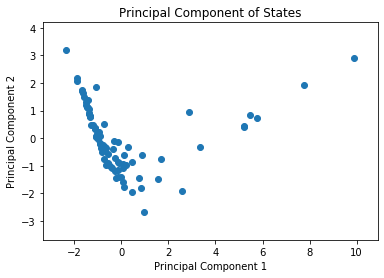

In [32]:
dat=Database[['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']].dropna()
sca=scale(dat)
pca_model = PCA()
X_PCA = pca_model.fit_transform(sca)
fig, ax = plt.subplots()
ax.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)
plt.scatter(X_PCA[:,0],X_PCA[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component of States')

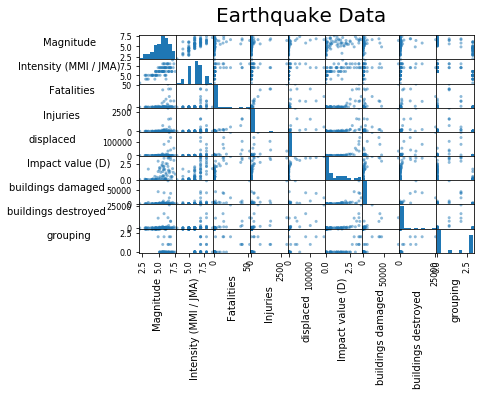

In [38]:
axs=pd.plotting.scatter_matrix(dat)
plt.suptitle('Earthquake Data', size=20)
n = len(dat.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

In [33]:
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

[0.57296607 0.17127359 0.10469433 0.06114026 0.04497316 0.02407714
 0.0156102  0.00526525]


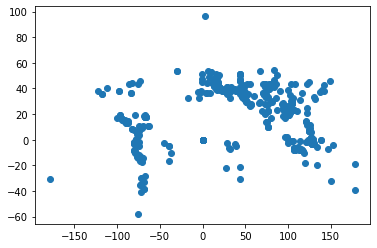

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8"])
plt.scatter(Database['Long'],Database['Lat'])

C:\Users\paulm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


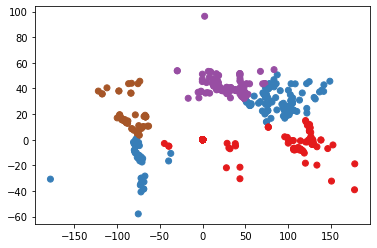

In [50]:
quac=earthquake_data[['Lat','Long']]
scal=scale(quac)
y_pred = KMeans(n_clusters=6,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
plt.scatter(quac['Long'],quac['Lat'],c=y_pred,cmap=cmap)

## Groupings for countries

C:\Users\paulm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


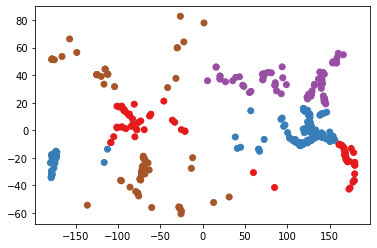

In [53]:
quac=Current[['lattitude','longitude']]
scal=scale(quac)
y_pred = KMeans(n_clusters=7,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
plt.scatter(quac['longitude'],quac['lattitude'],c=y_pred,cmap=cmap)

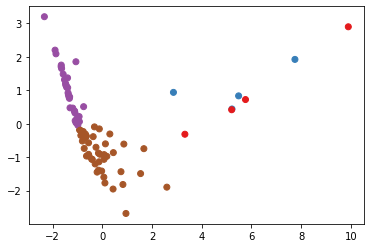

In [52]:
y_pred = KMeans(n_clusters=4).fit_predict(sca)
dat['grouping']=y_pred
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred,cmap=cmap)

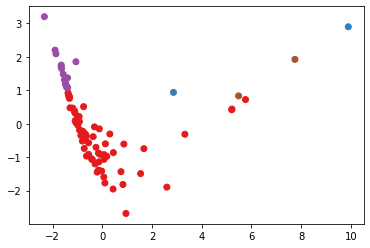

In [39]:
agg_cluster_model = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=7)
y_pred1 = agg_cluster_model.fit_predict(sca)
dat['grouping1']=y_pred1
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred1,cmap=cmap)

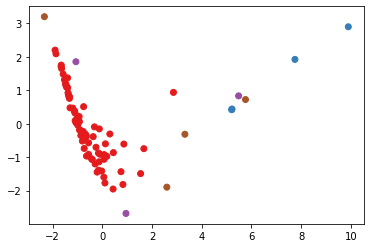

In [40]:
db_model = DBSCAN(eps=1, min_samples=1).fit(sca)
y_pred2 = db_model.fit_predict(sca)
dat['grouping2']=y_pred2
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred2,cmap=cmap)

In [60]:
earthquake_data.groupby(['Country']).get_group('USA')

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
52,2/17/2017,USA,Alabama,2.6,0.000,0.000,NaN,0.0,0.0,0.0,0.004031,1.0,0.0
64,3/7/2017,USA,Montana,3.4,0.000,0.000,NaN,0.0,0.0,0.0,0.031243,8.0,0.0
135,6/20/2017,USA,Georgia,3.2,0.000,0.000,NaN,0.0,0.0,0.0,0.004031,1.0,0.0
150,7/6/2017,USA,Montana,5.8,0.000,0.000,7.0,0.0,0.0,0.0,0.019789,5.0,0.0
285,1/4/2018,USA,California,4.4,0.000,0.000,5.0,0.0,0.0,0.0,0.004041,1.0,0.0
336,3/4/2018,USA,Oklahoma,4.2,0.000,0.000,5.0,0.0,0.0,0.0,0.004041,1.0,0.0
362,4/5/2018,USA,OS California,5.3,0.000,0.000,6.0,0.0,0.0,0.0,0.004041,1.0,0.0
380,5/1/2018,USA,Hawaii,4.2,0.000,0.000,NaN,0.0,0.0,0.0,0.019839,5.0,0.0
383,5/4/2018,USA,Hawaii,6.9,0.000,0.000,8.0,0.0,0.0,0.0,0.091211,25.0,0.0
401,5/16/2018,USA,Hawaii,4.4,0.000,0.000,NaN,0.0,0.0,0.0,0.019839,5.0,0.0
